## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from storesales.utils import save_submission
from storesales.advanced_predictor import AdvancedPredictor
from storesales.light_gbm.fit_evaluate.evaluate_models import evaluate
from storesales.light_gbm.utils import (
    make_submission_predictions,
    print_models_params,
    plot_feature_importance,
    load_family_lightgbm_and_dataset
)
from storesales.constants import (
    TEST_DATE_RANGE,
    MIDDLE_TEST_DATE,
    EXTERNAL_TRAIN_PATH,
    EXTERNAL_TEST_PATH,
)

## Load && Preprocess Data

In [3]:
train_df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])
test_df = pd.read_csv(EXTERNAL_TEST_PATH, parse_dates=["date"])

In [4]:
baseline_train_df = train_df.rename(columns={"date": "ds", "sales": "y"})
baseline_test_df = test_df.rename(columns={"date": "ds"})

### Load Baseline and LightGBM

In [5]:
baseline_model_file_paths = [
    "daily_predictor.pkl",
    "day_of_week_predictor.pkl",
    "weighted_day_predictor.pkl",
]
baseline_model_names = ["daily", "day_of_week", "weighted_day"]

In [6]:
families_for_lightgbm = ["EGGS", "LIQUOR,WINE,BEER", "MEATS", "POULTRY", "CELEBRATION"]
dir_suffixes = ["_default_model", "", "", "", "_default_model_mean_and_std_features"]

In [7]:
lightgbm_models = {}
family_datasets = {}

for family, suffix in zip(families_for_lightgbm, dir_suffixes):
    model, family_dataset = load_family_lightgbm_and_dataset(family, dir_suffix=suffix)
    lightgbm_models[family] = model
    family_datasets[family] = family_dataset

## Evaluate && Make Submission Prediction

In [8]:
eval_family_losses = evaluate(
    dataset=family_datasets,
    evaluate_range=TEST_DATE_RANGE,
    models=lightgbm_models,
    stride=1,
    parallel=True,
)

In [9]:
lightgbm_prediction_df = make_submission_predictions(
    family_datasets=family_datasets, models=lightgbm_models
)

100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


In [10]:
advanced_predictor = AdvancedPredictor(
    loss_split_date_str=MIDDLE_TEST_DATE,
    baseline_model_names=baseline_model_names,
    baseline_model_file_paths=baseline_model_file_paths,
    baseline_train_df=baseline_train_df,
    baseline_test_df=baseline_test_df,
    lightgbm_model_loss_df=eval_family_losses,
    lightgbm_model_prediction_df=lightgbm_prediction_df.reset_index(),
)

Fitting daily...


100%|██████████| 1782/1782 [00:00<00:00, 1782.67it/s]


Fitting day_of_week...


100%|██████████| 1782/1782 [00:03<00:00, 546.78it/s]


Fitting weighted_day...


100%|██████████| 1782/1782 [00:01<00:00, 1203.23it/s]


Predicting with daily...


100%|██████████| 1782/1782 [00:00<00:00, 3666.69it/s]


Predicting with day_of_week...


100%|██████████| 1782/1782 [00:00<00:00, 1819.74it/s]


Predicting with weighted_day...


100%|██████████| 1782/1782 [00:44<00:00, 39.78it/s]


## Plot Result

In [11]:
test_period = False

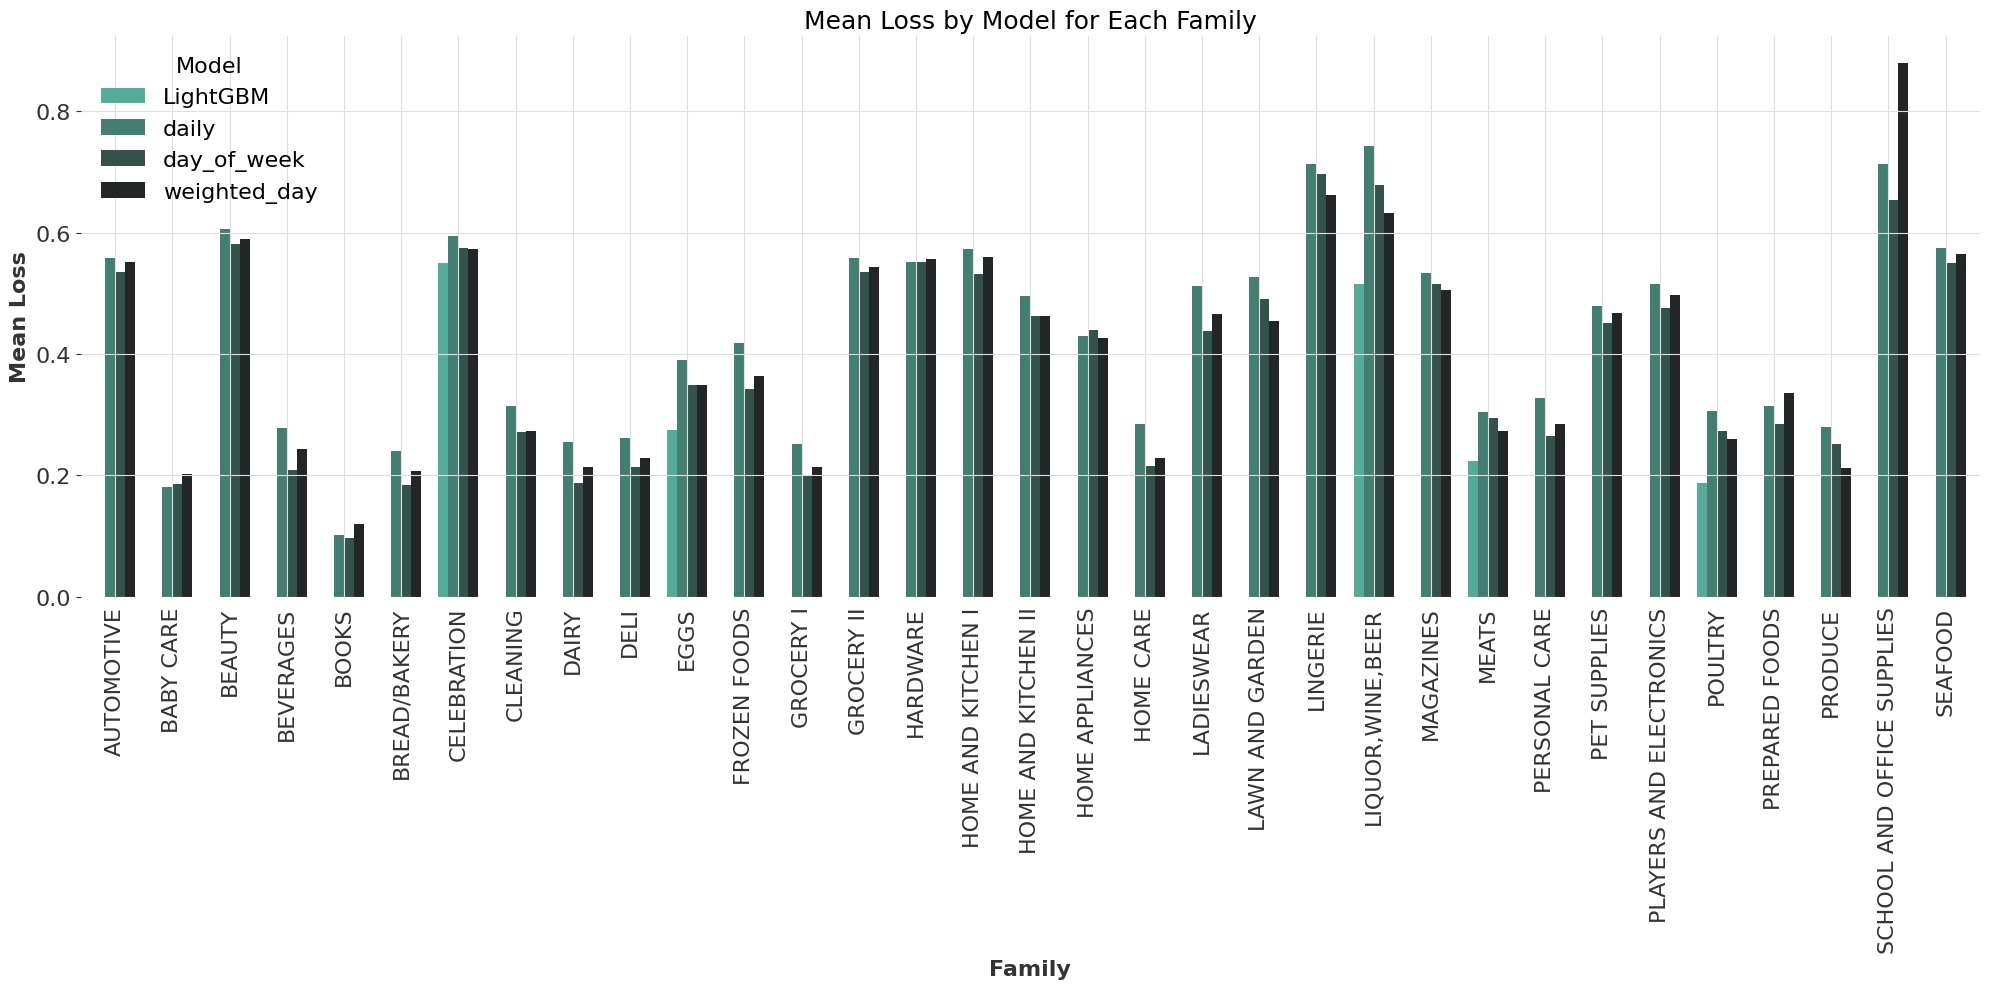

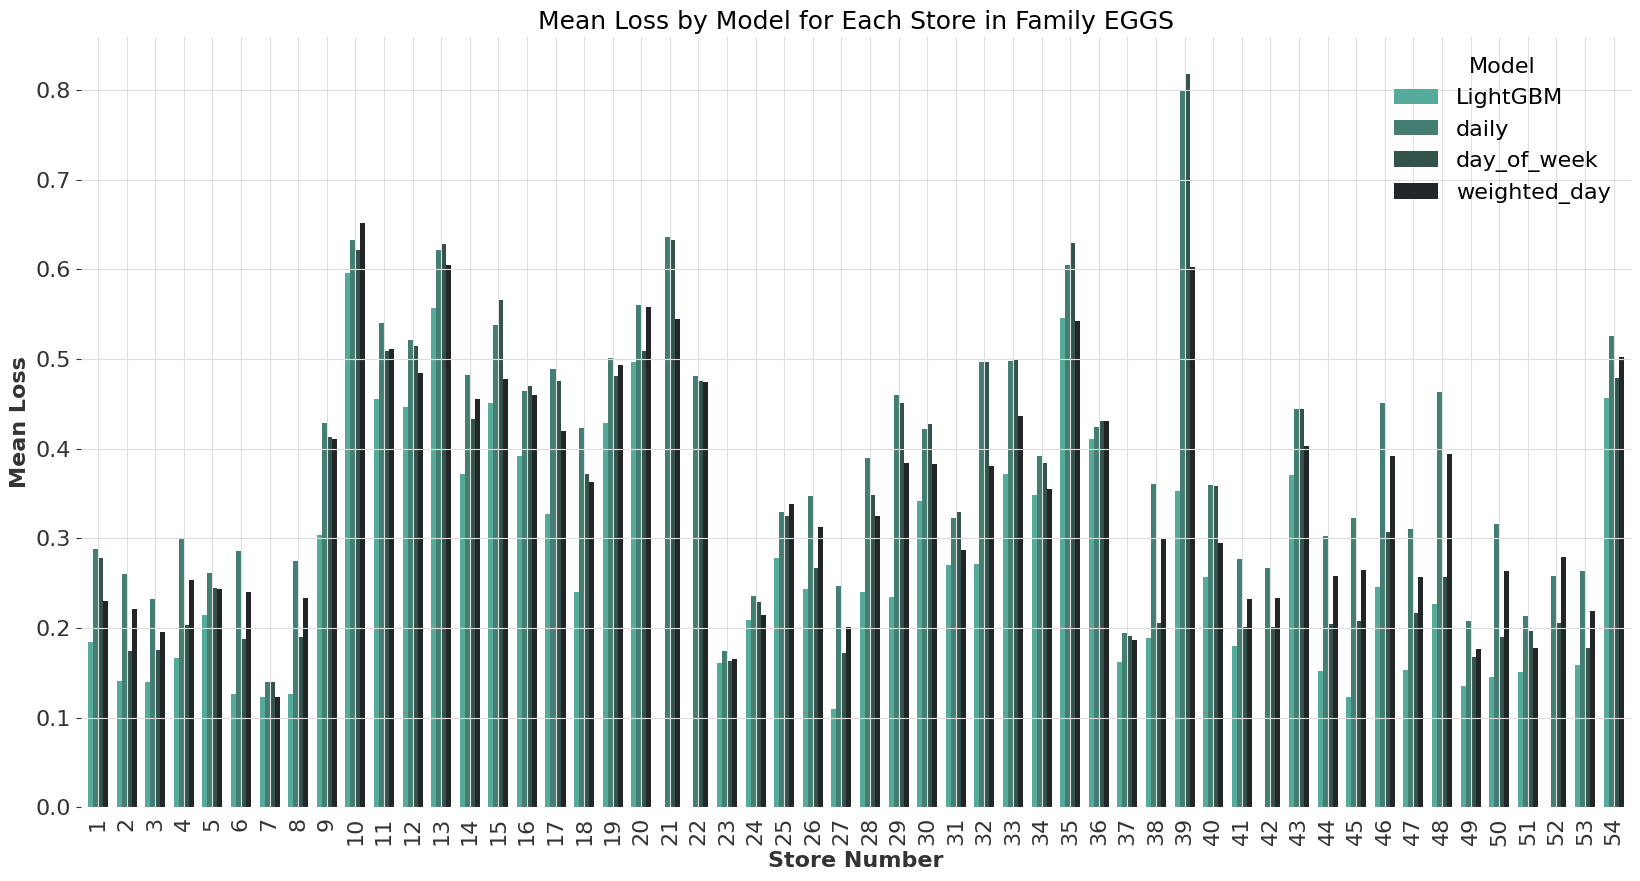

<Figure size 640x480 with 0 Axes>

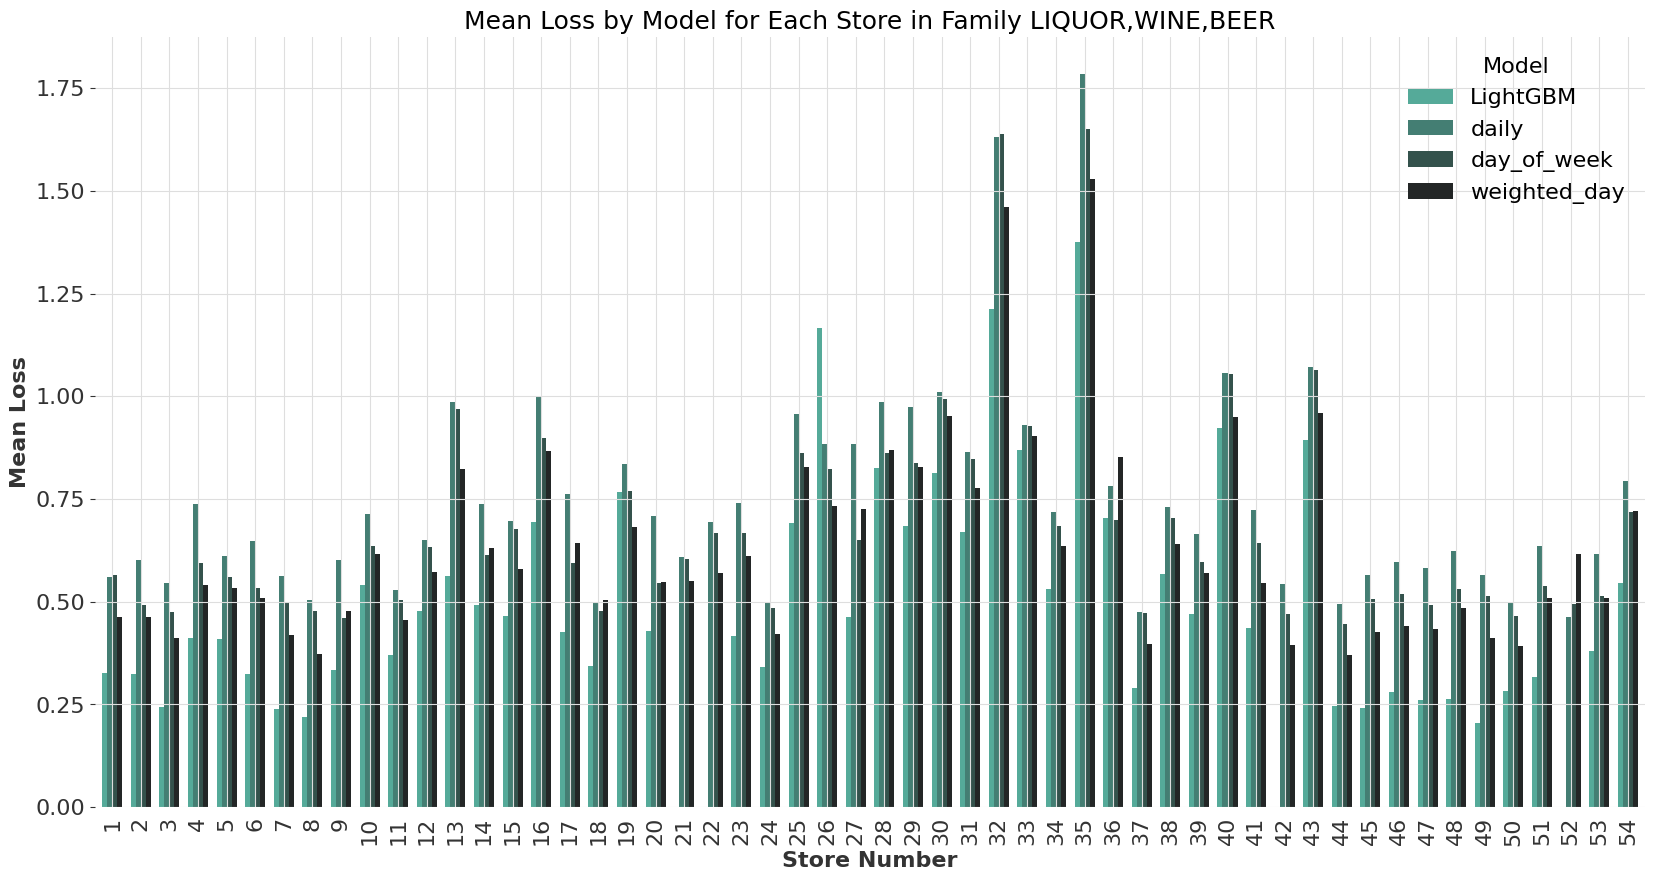

<Figure size 640x480 with 0 Axes>

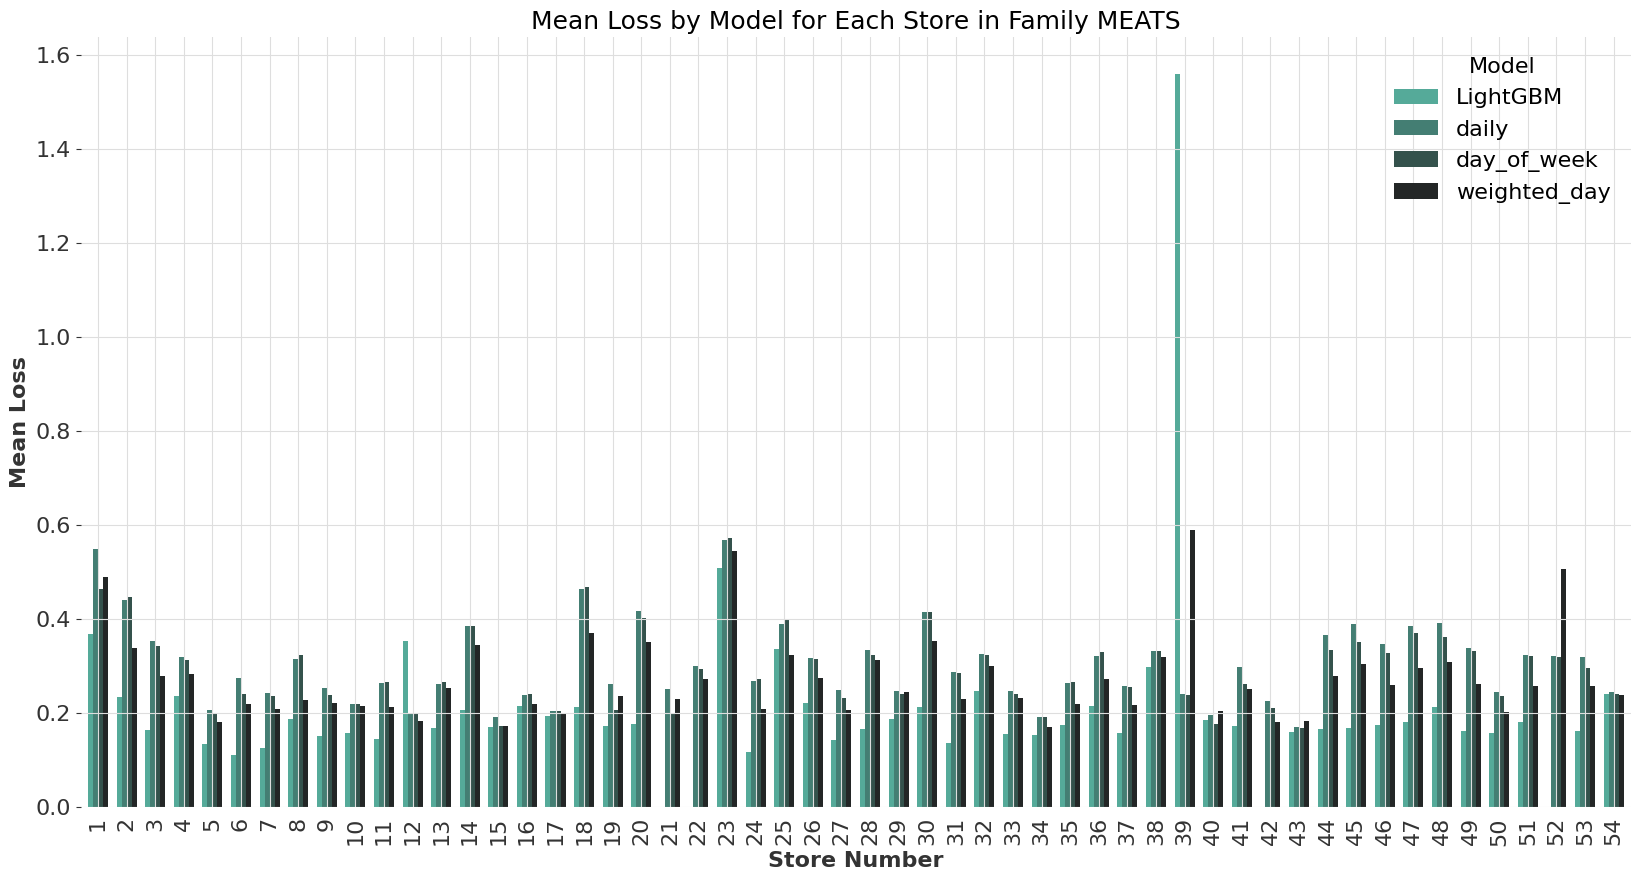

<Figure size 640x480 with 0 Axes>

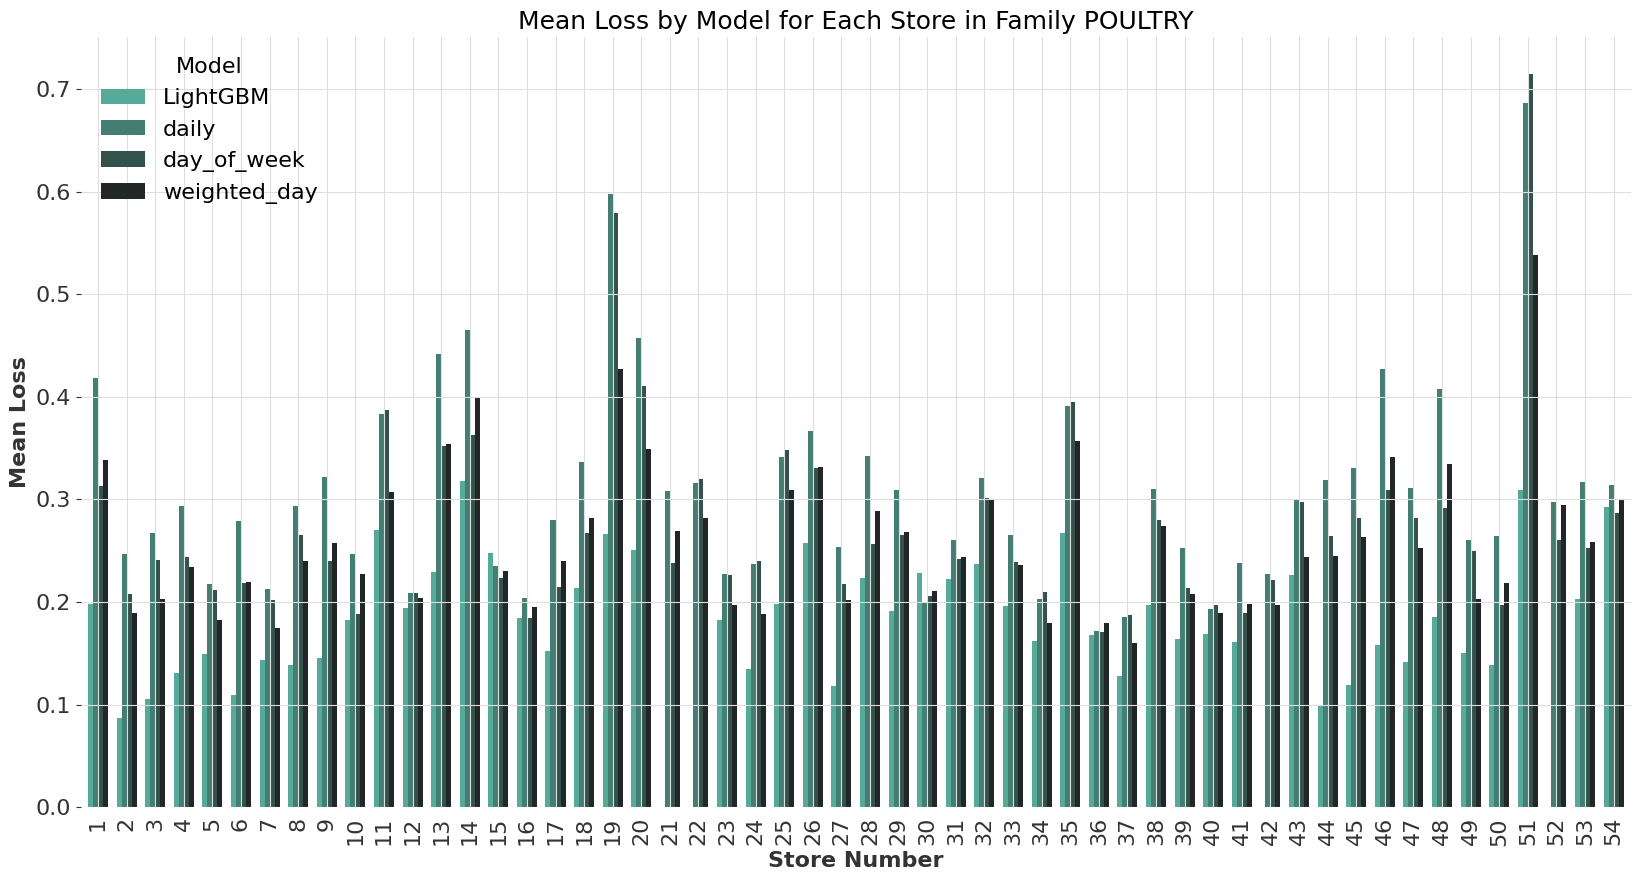

<Figure size 640x480 with 0 Axes>

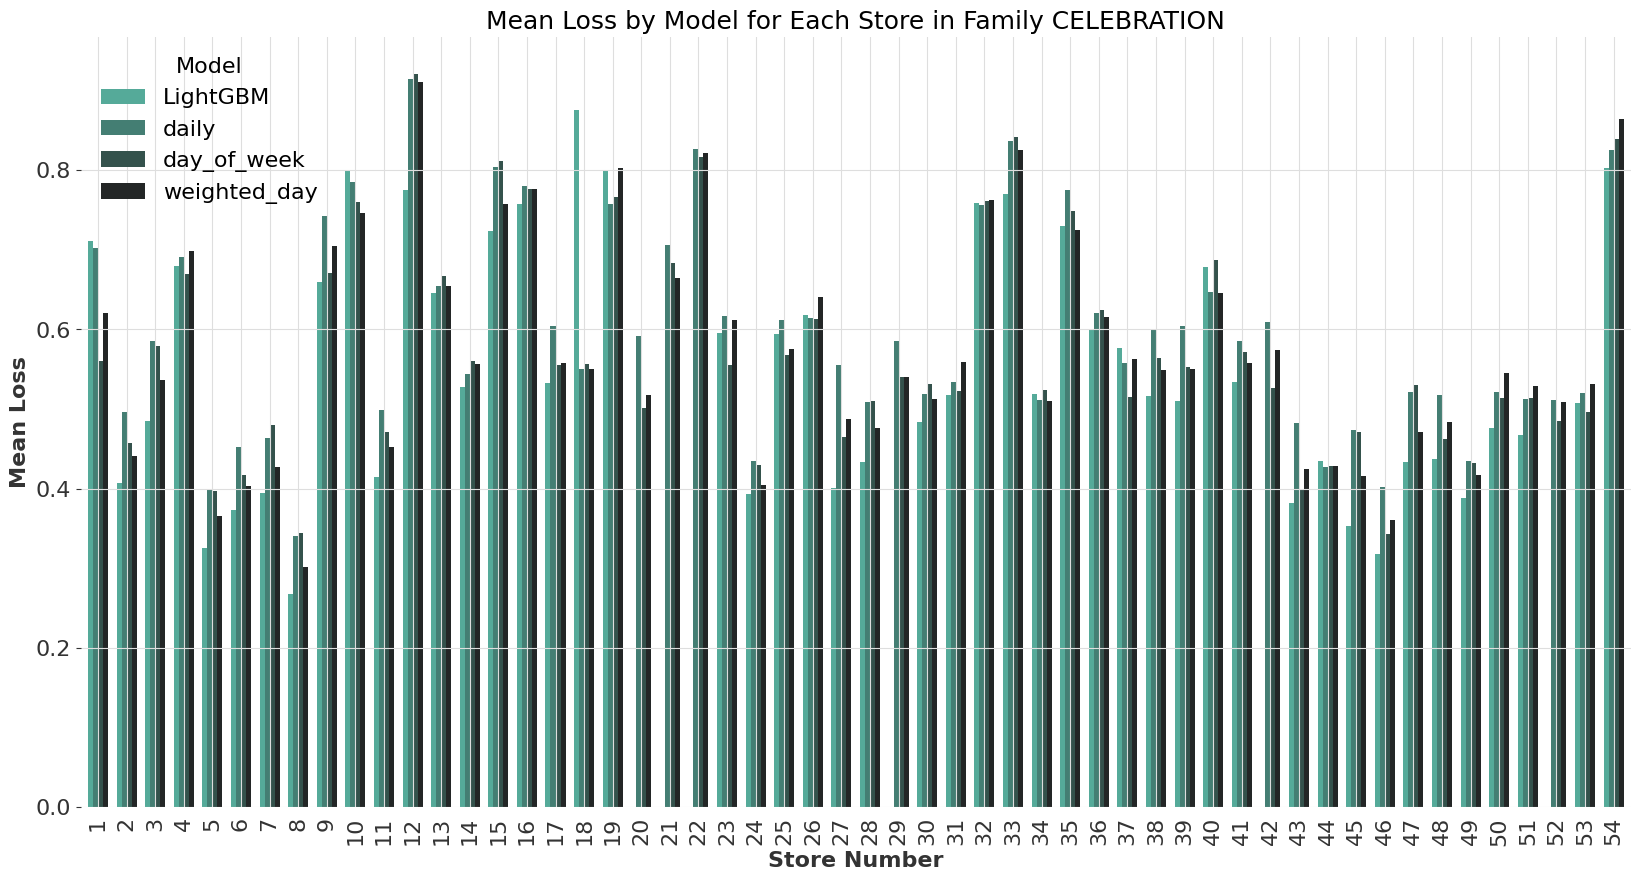

<Figure size 640x480 with 0 Axes>

In [12]:
advanced_predictor.make_overall_family_loss_plot(test_loss=test_period)

for family in family_datasets.keys():
    advanced_predictor.make_family_loss_plot(family=family, test_loss=test_period)

## Save Optimal Submission

In [13]:
lightgbm_drop_families = []

prediction_df = advanced_predictor.get_optimal_prediction(
    lightgbm_drop_families=lightgbm_drop_families
)

In [14]:
submission_df = save_submission(
    df=prediction_df, 
    file_name="best_families_and_celebration.csv"
)

Submission saved to /home/tikhon/PycharmProjects/StoreSales/data/submissions/best_families_and_celebration.csv
